In [1]:
from __future__ import division, print_function, absolute_import

import os
from timeit import time
import warnings
import sys
import cv2 as cv
import numpy as np
from PIL import Image
from yolo import YOLO
from matplotlib import pyplot as plt

from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet
from deep_sort.detection import Detection as ddet

%matplotlib inline
warnings.filterwarnings('ignore')

/Users/mengwan/anaconda/envs/SSD/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Definition of the parameters
max_cosine_distance = 0.3
nn_budget = None
nms_max_overlap = 1.0

# deep_sort 
model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)

In [3]:
yolo = YOLO()

model_data/yolo.h5 model, anchors, and classes loaded.


In [26]:
outputing = True 

vcap = cv.VideoCapture('./CAG/morning 0830/AB07-0830H (1).avi')
#vcap = cv.VideoCapture('./CAG/afternoon 1300/AB04-1300H.avi')
#vcap = cv.VideoCapture('./CAG/midnight 0200/AB07-0200H.avi')
#vcap = cv.VideoCapture('./CAG/rainy conditions/AB07-1600H.avi')
img_w = int(vcap.get(3))
img_h = int(vcap.get(4))
fps = vcap.get(cv.CAP_PROP_FPS)
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter('output.mp4', fourcc, fps, (img_w, img_h))

# lane area extremes
roi = [[200, 575], [130, 80], [260, 80], [767, 400], [767, 575], [200, 575]] # morning/AB07-1600H
#roi = [[0, 400], [0, 575], [767, 575], [470, 130], [320, 130], [0, 400]] # afternoon/AB04-1300H
#roi = [[200, 575], [130, 80], [260, 80], [767, 400], [767, 575], [200, 575]] # rainy/AB07-1600H
#roi = [[250, 575], [767, 575], [767, 390], [260, 110], [160, 110], [250, 575]] # night/AB07-0200H

In [27]:
frame_idx = 0
proc_fps = 0.0
out_txt = open("./print_out.txt", 'w')

while True:
    ret, frame = vcap.read()  # frame shape 640*480*3
    if ret != True:
        break;
    t1 = time.time()

    image = Image.fromarray(frame)
    boxs = yolo.detect_image(image) # x,y,w,h, score, class
    
    # separate out score, class info from loc
    scores_classes = [box[-2:] for box in boxs]
    boxs = [box[0:4] for box in boxs]
    features = encoder(frame,boxs)

    # score to 1.0 here).
    detections = [Detection(bbox, 1.0, feature) for bbox, feature in zip(boxs, features)]
    
    # filter unwanted obj by classfication
    for idx, det in list(enumerate(detections)):
        det.score = "%.2f" % scores_classes[idx][0]
        det.cls = scores_classes[idx][1]
    detections = [det for det in detections if yolo.class_names[det.cls] in ['person', 'bicycle', 'car',
                                                                             'motorbike', 'aeroplane',
                                                                             'bus', 'train', 'truck']]
    
    # filter detections with roi
    detections = [det for det in detections if 0 < cv.pointPolygonTest(np.array(roi),
                                                                       (det.to_xyah()[0], det.to_xyah()[1]),
                                                                       False)]
    
    # Run non-maxima suppression.
    boxes = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    indices = preprocessing.non_max_suppression(boxes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    # Call the tracker
    tracker.predict()
    tracker.update(detections)

    for track in tracker.tracks:
        if track.is_confirmed() and track.time_since_update > 1 :
            continue 
        bbox = track.to_tlbr()
        cv.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,255,255), 1)
        cv.putText(frame, str(track.track_id),(int(bbox[0]), int(bbox[1])-3),0, 5e-3 * 100, (0,255,0), 1)
        # update track speed in y direction, in pixels/seconds
        if not hasattr(track, 'first_frame'):
            track.first_frame = frame_idx
            track.first_bbox = track.to_tlwh()
        if frame_idx > track.first_frame + 1 * fps:
            cur_bbox = track.to_tlwh()
            cur_c_y = (cur_bbox[1] + cur_bbox[3] /2)
            first_c_y = (track.first_bbox[1] + track.first_bbox[3] /2)
            track.speed = (cur_c_y - first_c_y) / (frame_idx - track.first_frame) * fps
            
    for det in detections:
        bbox = det.to_tlbr()
        cv.rectangle(frame,(int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),(255,0,0), 1)
        cv.putText(frame, 
                   ' ' + yolo.class_names[det.cls] + ' ' + str(det.score),
                   (int(bbox[0])+3, int(bbox[1])-3), 0, 5e-3 * 100, (0,255,0),1)
    
    # Add aggregated data
    speeds = [abs(track.speed) for track in tracker.tracks if hasattr(track, 'speed')]
    avg_spd = np.sum(speeds) / len(speeds) * 0.0005787 * 3600 # km/hr
    lane_area = cv.contourArea(np.array(roi))
    box_area = np.sum([det.tlwh[2] * det.tlwh[3] for det in detections])
    occupancy = box_area / lane_area
    cv.putText(frame, 'detections: %d' % len(detections), (5, img_h-48), 0, 5e-3 * 150, (0,255,0), 1)
    cv.putText(frame, 'avergate speed: %.2f' % avg_spd, (5, img_h-28), 0, 5e-3 * 150, (0,255,0), 1)
    cv.putText(frame, 'occupancy: %.2f' % occupancy, (5, img_h-8), 0, 5e-3 * 150, (0,255,0), 1)
    
    if outputing:
        out.write(frame)
    
    frame_idx += 1

    proc_fps  = ( proc_fps + (1./(time.time()-t1)) ) / 2
    print("fps= %f"%(proc_fps))
    
    out_txt.write('{} vehicles detected, with average speed at {:.1f} km/h. {:.2f}% of the road surface is occupied.\n'.format(len(detections), avg_spd, occupancy))  
    
    if frame_idx >= 5:
        break

out_txt.close()

fps= 0.238054
fps= 0.269691
fps= 0.266708
fps= 0.269584
fps= 0.260498


In [29]:
vcap.release()
out.release()

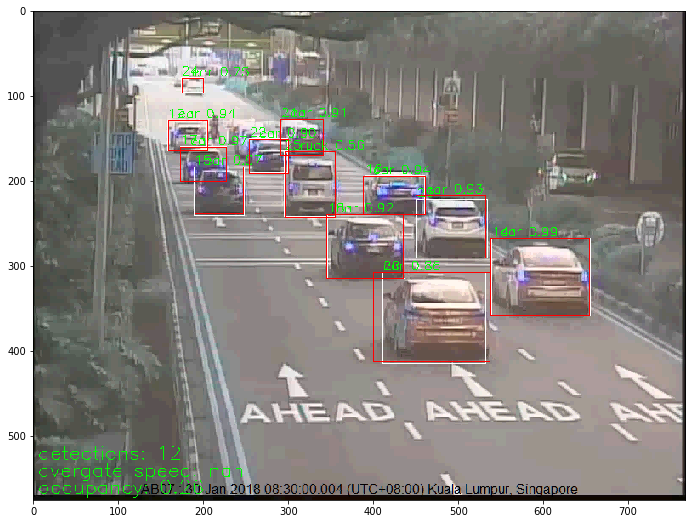

In [28]:
plt.figure(figsize=(16, 9))
plt.imshow(frame)